## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU (CUDA).")
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    print("The code will run on GPU (MPS).")
    device = torch.device('mps')
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
    device = torch.device('cpu')

The code will run on GPU (MPS).


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='../data'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Let's look at some images from our data 

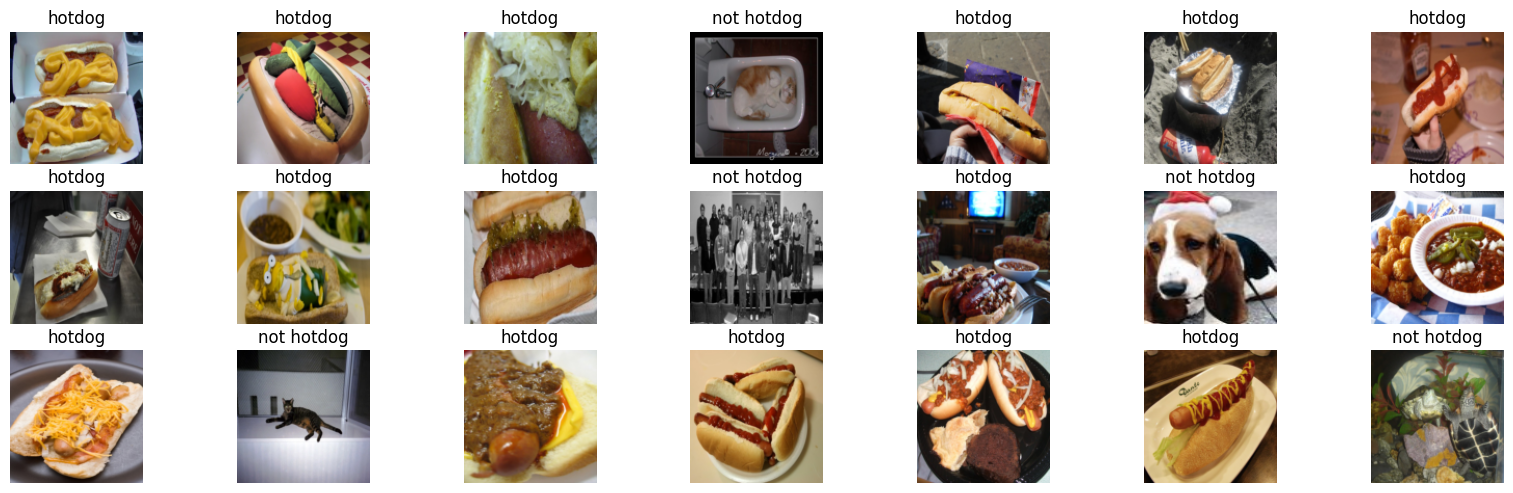

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) #Out_channels = how many filters we want, kernel_size = filter size 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) #Padding=1 to keep the image size same after convolution
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) #TA said pyramid shape often works well
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #Reduces the size of the image by a factor of 2. For 128x128 -> 64x64
        self.flatten = nn.Flatten() #Flattens the 3D tensor to 1D tensor
        self.fc1 = nn.Linear(64 * 16 * 16, 64) #Fully connected layer. Input size is 64 channels * 16 * 16 (after 3 maxpooling layers)
        self.fc2 = nn.Linear(64, 2) #2 output classes: hotdog and not hotdog
        self.dropout = nn.Dropout(p=0.5) #Regularization technique to prevent overfitting. Sets 50% of the neurons to 0 during training

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #ReLU activation function introduces non-linearity
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        #x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
model = SimpleCNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
Loss_function = nn.CrossEntropyLoss() #For binary classification problems

In [8]:

def train(model, optimizer, num_epochs=10):
    """
    Uses globals: train_loader, test_loader, device, Loss_function (CrossEntropyLoss).
    Returns out_dict with keys: train_acc, test_acc, train_loss, test_loss.
    """
    model.to(device)
    best_acc = 0.0

    out_dict = {
        'train_acc':  [],
        'test_acc':   [],
        'train_loss': [],
        'test_loss':  []
    }

    for epoch in range(num_epochs):
        # ---------- TRAIN ----------
        model.train()
        train_loss_sum = 0.0
        train_correct  = 0
        train_total    = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [train]"):
            images = images.to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad(set_to_none=True)
            logits = model(images)                   # logits [N, C]
            loss = Loss_function(logits, labels)     # CrossEntropyLoss
            loss.backward()
            optimizer.step()

            bs = labels.size(0)
            train_loss_sum += loss.item() * bs
            preds = logits.argmax(1)
            train_correct += (preds == labels).sum().item()
            train_total   += bs

        train_loss = train_loss_sum / max(1, train_total)
        train_acc  = train_correct  / max(1, train_total)

        # ---------- TEST / EVAL ----------
        model.eval()
        test_loss_sum = 0.0
        test_correct  = 0
        test_total    = 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [eval]", leave=False):
                images = images.to(device)
                labels = labels.to(device).long()

                logits = model(images)
                loss = Loss_function(logits, labels)

                bs = labels.size(0)
                test_loss_sum += loss.item() * bs
                preds = logits.argmax(1)
                test_correct  += (preds == labels).sum().item()
                test_total    += bs

        test_loss = test_loss_sum / max(1, test_total)
        test_acc  = test_correct  / max(1, test_total)

        # store with your exact names
        out_dict['train_loss'].append(train_loss)
        out_dict['test_loss'].append(test_loss)
        out_dict['train_acc'].append(train_acc)   # fractions 0..1
        out_dict['test_acc'].append(test_acc)     # fractions 0..1

        # save best by test_acc
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), "best_simplecnn.pth")

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"train_loss {train_loss:.4f} | train_acc {train_acc*100:.2f}% | "
            f"test_loss {test_loss:.4f} | test_acc {test_acc*100:.2f}% "
            f"(best {best_acc*100:.2f}%)"
        )

    return out_dict

In [ ]:
metrics = train(model, optimizer)

Epoch 1/10 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 [eval]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/10 | train_loss 0.6551 | train_acc 61.50% | test_loss 0.5715 | test_acc 71.37% (best 71.37%)


Epoch 2/10 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 [eval]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/10 | train_loss 0.5545 | train_acc 73.33% | test_loss 0.5551 | test_acc 71.64% (best 71.64%)


Epoch 3/10 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 [eval]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/10 | train_loss 0.5308 | train_acc 74.35% | test_loss 0.5562 | test_acc 71.37% (best 71.64%)


Epoch 4/10 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 [eval]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/10 | train_loss 0.5049 | train_acc 76.84% | test_loss 0.5428 | test_acc 74.01% (best 74.01%)


Epoch 5/10 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 [eval]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/10 | train_loss 0.4985 | train_acc 76.50% | test_loss 0.5256 | test_acc 73.42% (best 74.01%)


Epoch 6/10 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 [eval]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/10 | train_loss 0.4692 | train_acc 77.97% | test_loss 0.5303 | test_acc 74.87% (best 74.87%)


Epoch 7/10 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 [eval]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/10 | train_loss 0.4544 | train_acc 79.14% | test_loss 0.5161 | test_acc 75.78% (best 75.78%)


Epoch 8/10 [train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 [eval]:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
plt.plot([x*100 for x in metrics['train_acc']], label='Train acc')
plt.plot([x*100 for x in metrics['test_acc']],  label='Test acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.show()

plt.plot(metrics['train_loss'], label='Train loss')
plt.plot(metrics['test_loss'],  label='Test loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()